Driver:

    - cores: 1
    - coreLimit: "1200m"
    - memory: "2g"

Executor:

    - cores: 1
    - coreLimit: "2000m"
    - instances: 2
    - memory: "1500m"

18/12/2025
9h32min
9h41min

Commit 

In [20]:
import sys
from pathlib import Path

import pandas as pd

# Add the notebooks directory to the path
sys.path.append(str(Path.cwd().parent))

from charts import (
    latency_box_plot,
    latency_distribution_plot,
    latency_line_plot,
)
from functions import calculate_latencies
from utils import fix_timestamps_timezone

experiment_name = "experiment07"

df_cloud = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-12-19-20_42_31-avro-cloud.parquet")
df_cloud = df_cloud.sort_values("source_timestamp")
df_edge = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-12-19-20_49_14-avro-edge.parquet")
df_edge = df_edge.sort_values("source_timestamp")

In [21]:
df_cloud = fix_timestamps_timezone(df_cloud)
df_edge = fix_timestamps_timezone(df_edge)

In [22]:
from sklearn.mixture import GaussianMixture

def compensate_clock_drift(df):
    # Calculate raw drift (ms): Broker Arrival - Source Generation
    df['raw_source_kafka_latency'] = (df['timestamp'] - df['source_timestamp']).dt.total_seconds() * 1000

    # 3. Clustering (3 Brokers)
    X = df['raw_source_kafka_latency'].values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=3, random_state=42, n_init=10)
    df['cluster'] = gmm.fit_predict(X)
    
    # 4. Define Reference (Cluster 0 as no-drift reference)
    # We find the actual cluster ID that has a median closest to 35.28ms 
    # (to ensure the code remains robust if GMM re-orders labels)
    medians = df.groupby('cluster')['raw_source_kafka_latency'].median()
    ref_cluster = medians.iloc[(medians - 35.28).abs().argsort()[:1]].index[0]
    ref_value = medians[ref_cluster]
    
    print(f"\nReference Cluster identified as: {ref_cluster} (Median: {ref_value:.2f} ms)")

    # 5. Calculate Systematic Error relative to Reference
    # drift_to_compensate = Cluster_Median - Reference_Median
    cluster_offsets = (medians - ref_value).to_dict()
    
    print("\nCalculated Clock Offsets (Relative to Reference):")
    for cluster, offset in cluster_offsets.items():
        note = "(Reference)" if cluster == ref_cluster else ""
        print(f" Cluster {cluster}: {offset:+.2f} ms {note}")

    # 6. Compensate Data Points
    # We only remove the delta between brokers. 
    # This keeps the "real" latency (approx 35ms base) intact.
    df['source_kafka_latency'] = df.apply(
        lambda row: row['raw_source_kafka_latency'] - cluster_offsets[row['cluster']], axis=1
    )

    return df

In [ ]:
df_cloud = calculate_latencies(df_cloud)
df_edge = calculate_latencies(df_edge)

In [27]:
df_edge = compensate_clock_drift(df_edge)


Reference Cluster identified as: 1 (Median: 35.28 ms)

Calculated Clock Offsets (Relative to Reference):
 Cluster 0: -967.13 ms 
 Cluster 1: +0.00 ms (Reference)
 Cluster 2: +75.46 ms 


In [28]:
start_time = pd.Timestamp("2025-12-19 18:00:00", tz="UTC")
end_time = pd.Timestamp("2025-12-19 20:30:00", tz="UTC")

df_cloud_filtered = df_cloud[
    (df_cloud["source_timestamp"] >= start_time) &
    (df_cloud["source_timestamp"] <= end_time)
]

df_edge_filtered = df_edge[
    (df_edge["source_timestamp"] >= start_time) &
    (df_edge["source_timestamp"] <= end_time)
]

/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1491: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  long_df.groupby(["stage", "environment"])["latency_s"]


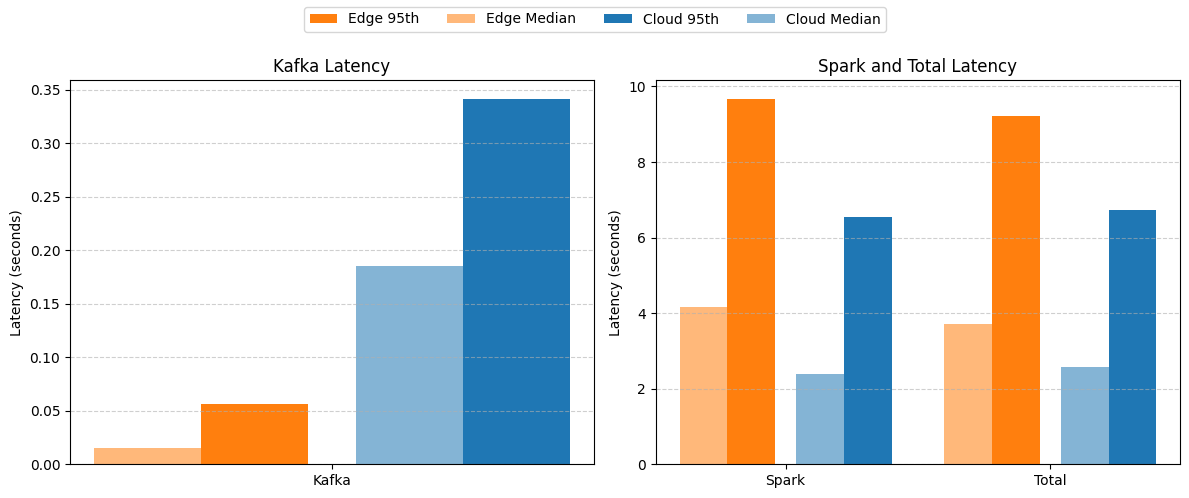

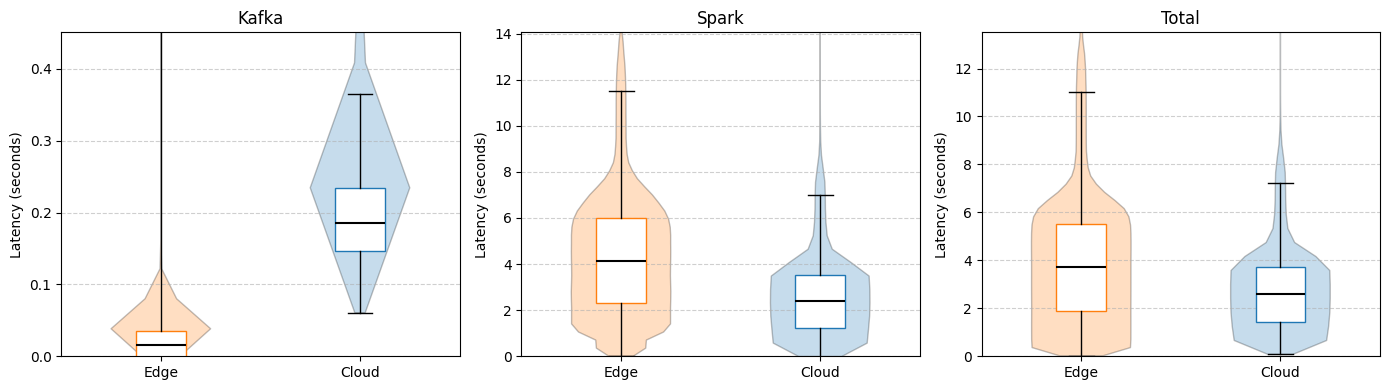

In [12]:
from charts import latency_summary_bar_chart, latency_violin_box_overlay

# Ensure a common schema like: ['environment', 'stage', 'latency_s']
df_edge["environment"] = "Edge"
df_cloud["environment"] = "Cloud"
df = pd.concat([df_edge,df_cloud], ignore_index=True)

df_cloud
# Now plot
latency_summary_bar_chart(df, save_path="./latency_summary.png")
latency_violin_box_overlay(df, save_path="./latency_violin.png")

In [13]:
import numpy as np
from charts import _prepare_latency_long


def summarize_latencies_ms(df: pd.DataFrame) -> pd.DataFrame:
    long_df = _prepare_latency_long(df)
    summ = (
        long_df.groupby(["stage", "environment"])["latency_s"]
        .agg(
            median=lambda s: np.nanmedian(s),
            iqr=lambda s: np.nanpercentile(s, 75) - np.nanpercentile(s, 25),
            p95=lambda s: np.nanpercentile(s, 95),
        )
        .mul(1000)  # seconds -> milliseconds
        .round(1)   # 0.1 ms resolution is sufficient for reporting
        .reset_index()
        .pivot(index=["stage"], columns="environment")
        .sort_index()
    )
    # Make a flat column index like 'median.Edge (ms)'
    summ.columns = [f"{stat}.{env} (ms)" for stat, env in summ.columns]
    return summ

stats_ms = summarize_latencies_ms(df)
display(stats_ms)

# Convenience accessors for your paragraph (edit rounding as you prefer)
def val(stage, stat, env):
    return float(stats_ms.loc[stage, f"{stat}.{env} (ms)"])

k_edge_med   = val("Kafka", "median", "Edge")
k_edge_p95   = val("Kafka", "p95",    "Edge")
k_cloud_med  = val("Kafka", "median", "Cloud")
k_cloud_p95  = val("Kafka", "p95",    "Cloud")

s_edge_med   = val("Spark", "median", "Edge")
s_cloud_med  = val("Spark", "median", "Cloud")
s_cloud_p95  = val("Spark", "p95",    "Cloud")

t_edge_med   = val("Total", "median", "Edge")
t_cloud_med  = val("Total", "median", "Cloud")
t_cloud_p95  = val("Total", "p95",    "Cloud")

print(
    f"Kafka — Edge median: {k_edge_med:.1f} ms; Edge P95: {k_edge_p95:.1f} ms; "
    f"Cloud median: {k_cloud_med:.1f} ms; Cloud P95: {k_cloud_p95:.1f} ms."
)
print(
    f"Spark — Edge median: {s_edge_med:.1f} ms; Cloud median: {s_cloud_med:.1f} ms; "
    f"Cloud P95: {s_cloud_p95:.1f} ms."
)
print(
    f"Total — Edge median: {t_edge_med:.1f} ms; Cloud median: {t_cloud_med:.1f} ms; "
    f"Cloud P95: {t_cloud_p95:.1f} ms."
)

# Optional: a ready-to-paste sentence that mirrors your paragraph but with exact numbers
print(
    "\nSentence for the paper:\n"
    f"Edge ingestion remained below approximately {k_edge_med:.0f} ms for most of the distribution, "
    f"with a 95th percentile of {k_edge_p95:.0f} ms, while the cloud presented a wider spread with a "
    f"median of {k_cloud_med:.0f} ms and tails reaching {k_cloud_p95:.0f} ms. "
    f"Persistence latency dominated the end-to-end budget, with edge median values of {s_edge_med:.0f} ms "
    f"and cloud of {s_cloud_med:.0f} ms, and a cloud 95th percentile of {s_cloud_p95:.0f} ms."
)

/tmp/ipykernel_3139/3164325065.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  long_df.groupby(["stage", "environment"])["latency_s"]


,median.Cloud (ms),median.Edge (ms),iqr.Cloud (ms),iqr.Edge (ms),p95.Cloud (ms),p95.Edge (ms)
stage,,,,,,
Kafka,185.3,15.1,87.3,967.1,341.6,56.6
Spark,2384.0,4153.0,2315.0,3668.0,6538.0,9679.0
Total,2581.2,3707.3,2315.8,3661.1,6735.6,9229.1


Kafka — Edge median: 15.1 ms; Edge P95: 56.6 ms; Cloud median: 185.3 ms; Cloud P95: 341.6 ms.
Spark — Edge median: 4153.0 ms; Cloud median: 2384.0 ms; Cloud P95: 6538.0 ms.
Total — Edge median: 3707.3 ms; Cloud median: 2581.2 ms; Cloud P95: 6735.6 ms.

Sentence for the paper:
Edge ingestion remained below approximately 15 ms for most of the distribution, with a 95th percentile of 57 ms, while the cloud presented a wider spread with a median of 185 ms and tails reaching 342 ms. Persistence latency dominated the end-to-end budget, with edge median values of 4153 ms and cloud of 2384 ms, and a cloud 95th percentile of 6538 ms.


In [ ]:
p95_threshold = df['corrected_latency_ms'].quantile(0.95)
initial_count = len(df)
df = df[df['corrected_latency_ms'] <= p95_threshold].copy()
removed_count = initial_count - len(df)
print("\nOutlier Removal (P95):")
print(f" Threshold: {p95_threshold:.2f} ms")
print(f" Removed {removed_count} records (5% of data)")


Outlier Removal (P99):
 Threshold: 84.52 ms
 Removed 2941908 records


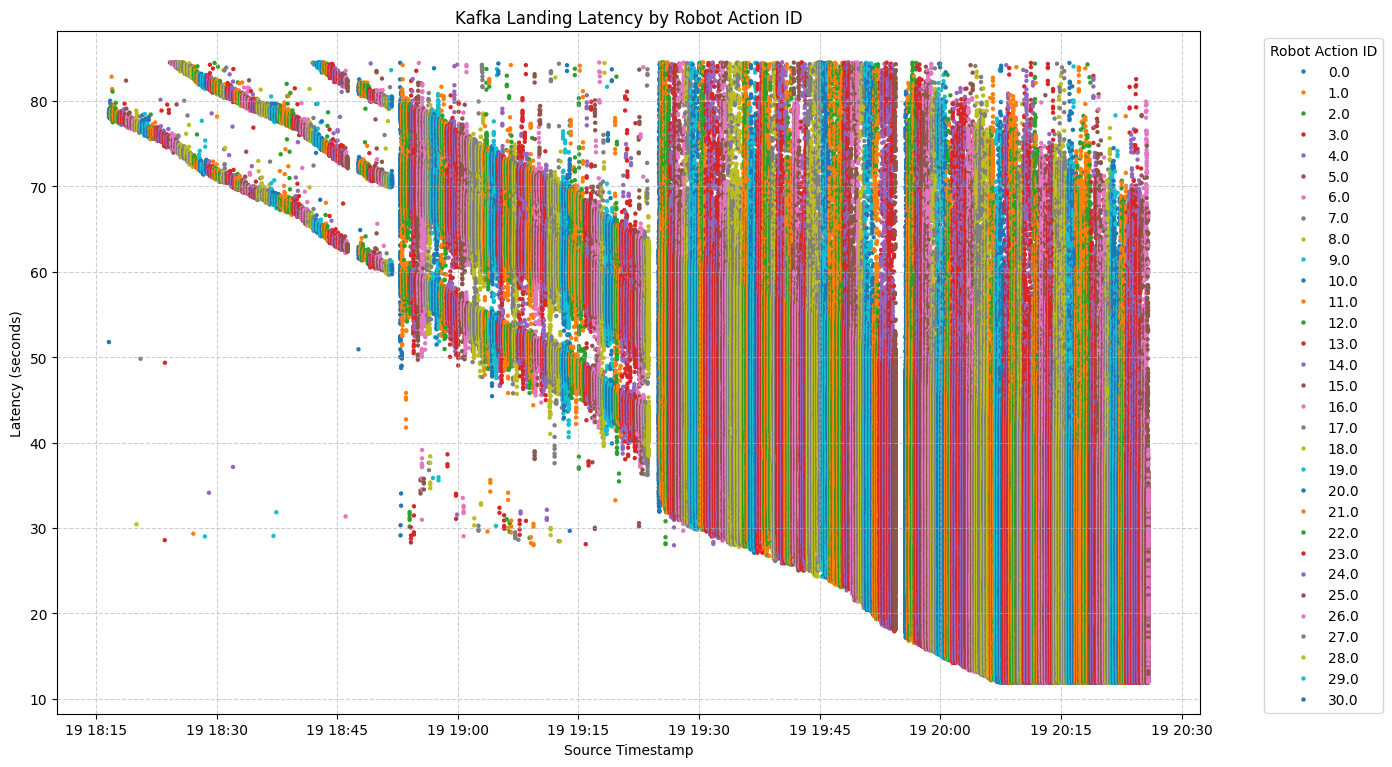

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter and sort the data subset
data_subset = df_edge_filtered.sort_values(by="source_timestamp")

p99_threshold = data_subset['source_kafka_latency'].quantile(0.995)
p01_threshold = data_subset['source_kafka_latency'].quantile(0.015)
initial_count = len(df)
data_subset = data_subset[(data_subset['source_kafka_latency'] <= p99_threshold) & (data_subset['source_kafka_latency'] > p01_threshold)].copy()
removed_count = initial_count - len(data_subset)
print("\nOutlier Removal (P99):")
print(f" Threshold: {p99_threshold:.2f} ms and {p01_threshold:.2f} ms")
print(f" Removed {removed_count} records")

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=data_subset,
    x="source_timestamp", 
    y="source_kafka_latency", 
    hue="robot_action_id",  # Colors points by robot_action_id
    palette="tab10",        # Choose a distinct color palette
    s=10,                   # Marker size
    marker='o',
    linewidth=0
)

plt.title("Kafka Landing Latency by Robot Action ID")
plt.xlabel("Source Timestamp")
plt.ylabel("Latency (seconds)")
plt.legend(title="Robot Action ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Claramente o clock drift não foi devidamente removido, pois ele cresceu linearmente durante o experimento.
Além disso mesmo com a técnica de clusterização os outliers não foram corretamente compensados.

/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


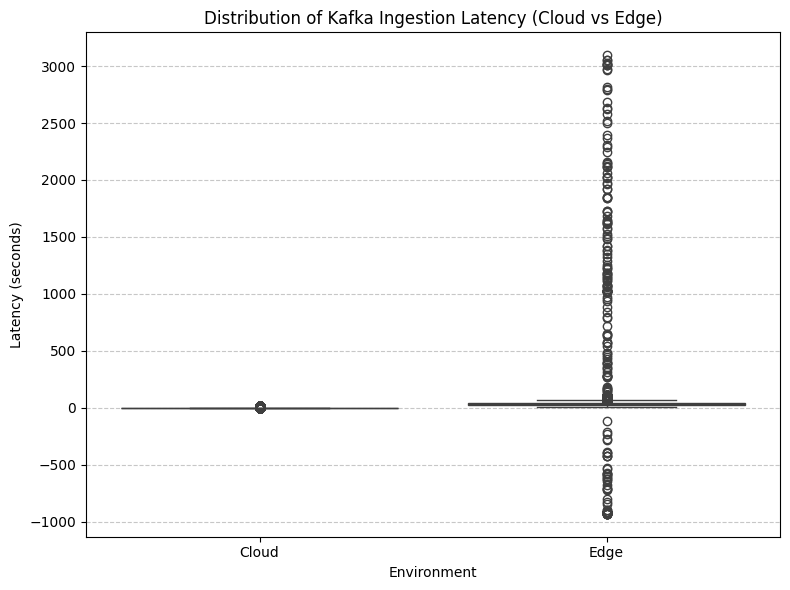

In [42]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="source_kafka_latency")

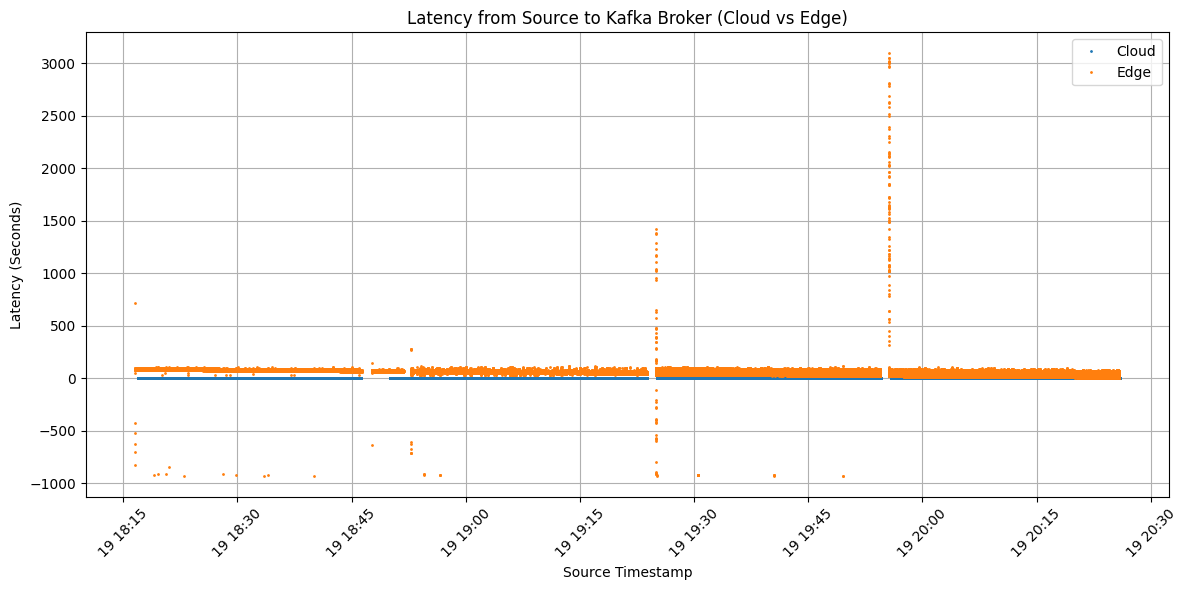

In [43]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x="source_timestamp", y="source_kafka_latency")

📊 Statistics:
                  mean     median        std
Environment                                 
Cloud         0.203218   0.185304   0.282325
Edge         36.943985  35.277000  18.378780


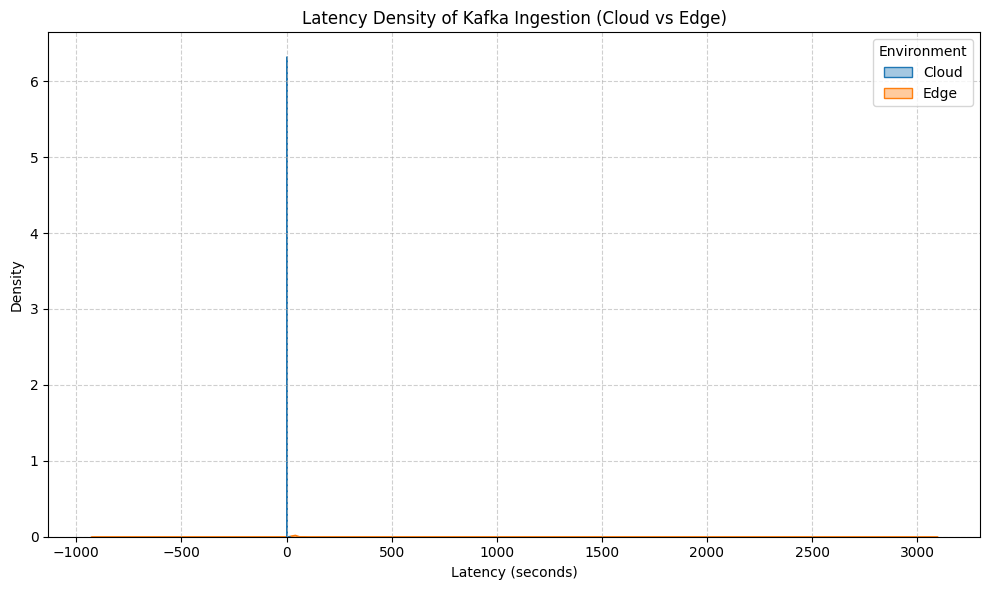

In [44]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="source_kafka_latency")

/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


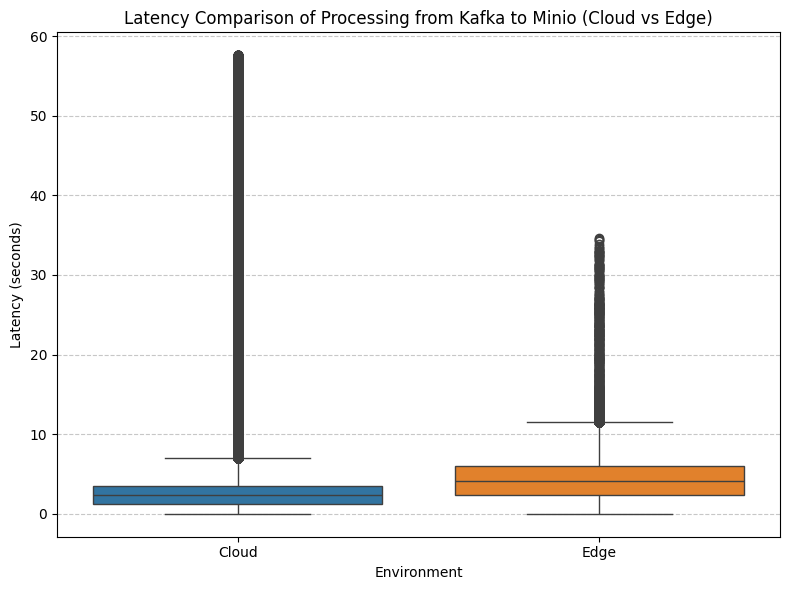

In [45]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="kafka_landing_latency", title="Latency Comparison of Processing from Kafka to Minio (Cloud vs Edge)")

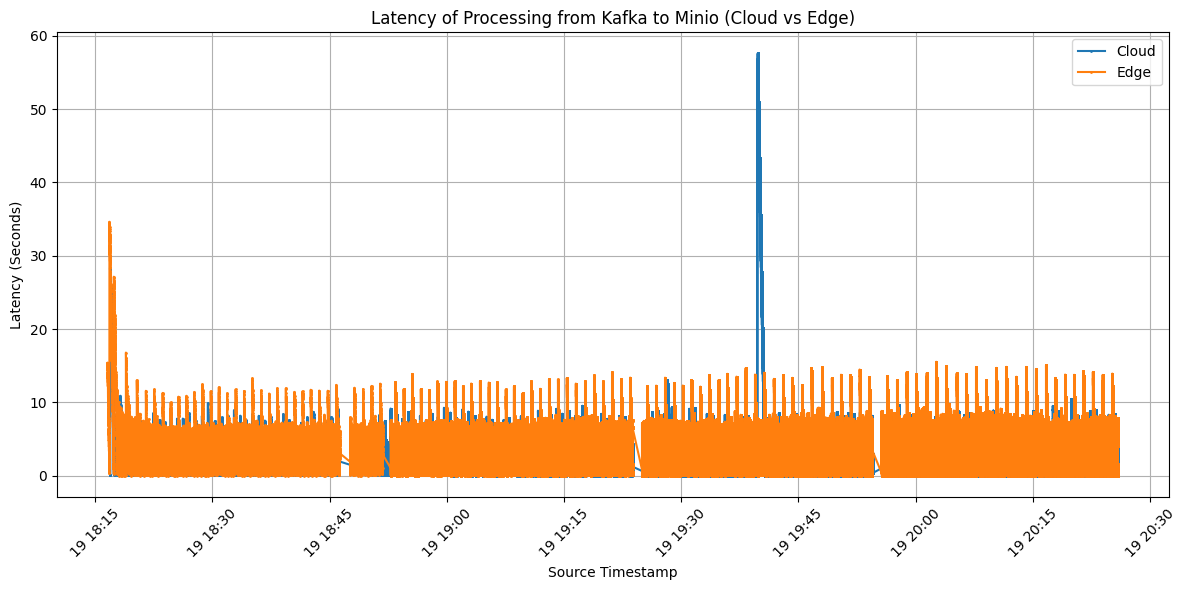

In [46]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x='source_timestamp', y='kafka_landing_latency', title='Latency of Processing from Kafka to Minio (Cloud vs Edge)', linestyle="solid")

📊 Statistics:
                 mean  median       std
Environment                            
Cloud        2.828304   2.384  3.619495
Edge         4.409493   4.153  2.709291


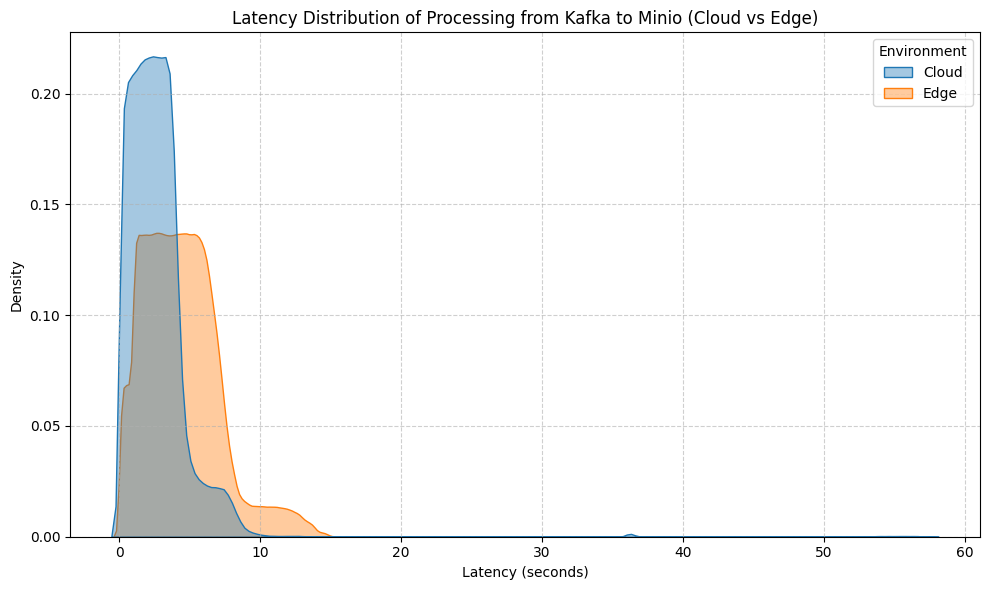

In [47]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="kafka_landing_latency", title="Latency Distribution of Processing from Kafka to Minio (Cloud vs Edge)")